# About

Prepared by Cameron Movassaghi in collaboration with Yuyang Han.
In participation of the BO Hackathon with Acceleration Consortium

This notebook is a walk-through of Bayesian optimization for rapid pulse voltammetry (RPV) waveforms. Specifically, we  seek to find a voltammetry waveform that yields maximal performance in detecting serotonin (i.e., minimal error for serotonin (5-HT) test set accuracy). See here for more on RPV: https://link.springer.com/article/10.1007/s00216-021-03665-1

Briefly, voltammetry is an electroanalytical technique capabable of measuring neurotransmitters in the brain, in real time. An excellent overview can be found here: https://pubs.rsc.org/en/content/articlelanding/2020/an/c9an01586h/unauth

By applying a voltage waveform (i.e., a varying voltage over time), electroactive chemicals such as serotonin oxidize and reduce at the surface of an implantable electrode sensor. The resulting current (voltammogram) contains information such as the identity of the analyte present and how much is there (concentration). By training chemometric models such as principal components regression, partial least squares regression, elastic net regression, or even more advanced models such as artificial neural networks, the identity and concentration of unknown samples can be predicted from unknown voltammograms. 

Voltammetry is a 'soft sensing' technique - many other chemicals other than the one of interest can give rise to signal because many compounds can oxidize and reduce at the sensor surface. Thus, one way to impart selecitvity is from the chemometric model training. However, another (often unexplored) way to impart selecitivity is to design a waveform specific for that analyte. The question is how? There are virtually infinite numbers of waveforms one could design. 

The main optimization problem is summarized below. Given some waveform, shown here as a simple pulse, we can go into lab test how well the waveforms works on the sensors in the lab. We do this by measuring our chemical of interest in various samples, and get some calculate some performance metric, such as sensor prediction error (the number shown below is arbritrary, this could be any number, so long as it is a measure of waveform performance). This is our black-box objective function. The only way to know this value is to test it experimentally. 

But what if we want to optimize this metric? There are few, if any, design principles in this domain to guide how to design a custom waveform for a specific use case. For example, one could vary the slope of the lines, the start and stop voltages, the time of each step, etc. One could even move to different shapes and so forth. There are many possibilities, but testing waveforms is a long and expensive process.

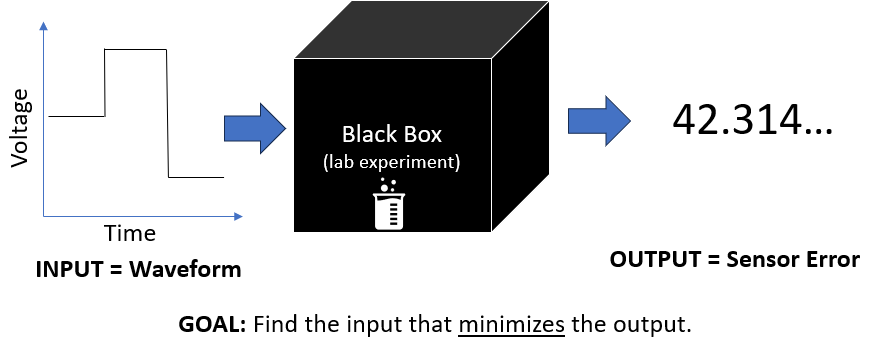

This is where Bayesian optimization can help to navigate this search space by dynamically learning what waveform patterns to explore and exploit over time, as more waveforms are tested.

Here, we use real world data from our lab of several dozen waveforms and how they performed on serotonin concentration prediction tasks. The exact details of the experimental set up are less relevant for this tutorial, but will be provided in a forthcoming manuscript.

We will start with 6 randomly generated waveforms, and use Bayesian optimization to predict the next best waveforms to test experimentally. We will do this piece by piece to simulate us actually going into the lab and collecting this data and coming back with the answer the optimizer asks for. Hence, this tutorial is meant to be written for experimentalists doing "ask/tell" or human-in-the-loop experiments, to show how such a process can be accomplished in something as simple as a Jupyter notebook.

We will be using the `scikit-optimize` (`skopt`) library (https://scikit-optimize.github.io/stable/). See official documentation for more information as needed. We will also be using the PyData stack (`numpy`, `pandas`, `scikit-learn`, and `matplotlib`).

Broadly speaking, this problem of developing methods to analyze chemical compounds but encountering intractable design spaces is common. Thus, while we use voltammetry waveforms as an example, the workflow below could be extend to any format where an analytical chemist is developing a chemical measurement method. For example, the waveform input could be instead be a chromatography gradient and the output a measure of peak separation.

# Import Packages

The following package versions were used. Run `!pip install <package> == <version>` if needed.

- ax-platform: 0.3.4
- scikit-learn: 1.2.1
- scikit-optimize: 0.9.0
- matplotlib: 3.7.0
- scipy: 1.7.3
- numpy: 1.22.4
- pandas: 1.5.3
- python: 3.10.9

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from skopt import Optimizer
from skopt.space import Real, Integer
from skopt.plots import *
from skopt import gp_minimize, forest_minimize, dummy_minimize
from skopt.utils import use_named_args

import sklearn.inspection 
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.metrics import r2_score
from sklearn.utils import resample
from sklearn.gaussian_process.kernels import *
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler


from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Experiment Set Up

First we define our search space. For reference: https://scikit-optimize.github.io/stable/modules/space.html

For simplicity, we will constrain ourselves to pulse waveforms with 4 steps (see below). Each step has a voltage and a time, labeled as given (E1, t1,...). This gives eight total parameters. 

For non-voltammetry experts, think of this simply as how you might rapidly roast coffee beans to yield a delicious tasting cup of coffee, where the waveform is just roasting temperature over time. You may have some guess of how to roast your beans, but let us limit ourselves to 4 'roasting' steps as noted. Then, you go and roast your beans using the waveform that is designed, and you rate how the coffee tastes. This is your objective to optimize. (in reality, our objective is how well the waveform measures known levels of serotonin, defined as mean absolute error; thus, a minimization task (we want as low error as possible)). 

We will constrain all tau (t) values to be any continuous value between 0.5 and 2.0 ms. In our coffee example, think of this simply as your prior domain knowledge that roasting beans in steps of this size is usually the best range. Similarly, for the voltage (or roasting temperature steps, for our coffee example), we have to stay between 0 and 1.3 for the first two, and 0 to -0.5 for the last two. For voltammetry experts, here is the real reason:

We constrain the first two pulses as anodic pulses (> 0 V vs Ag/AgCl, up to 1.3 V due to the solvent window) and the last two pulses as cathodic pulses (< 0 V vs Ag/AgCl, down to -0.5 V). All voltages throughout are assumed to be in Volts vs. Ag/AgCl. This encodes the pulse/counterpulse design heuristic from the voltammetric electronic tongue field.

Even with these constraints, this is where you can imagine the many possibilities. Changing the time step by as little as 0.1 ms or the voltage step by as little as .01 V can have major effects on the outcome (e.g., turn a great cup of coffee into a terrible one, or vice versa). There is no way to test all these waveforms but no way to evaluate waveforms without testing them. So our only hope is to test waveforms that are informative about where a good waveform may be in our design space.

You should change these constraints based on your knowledge of your problem space.

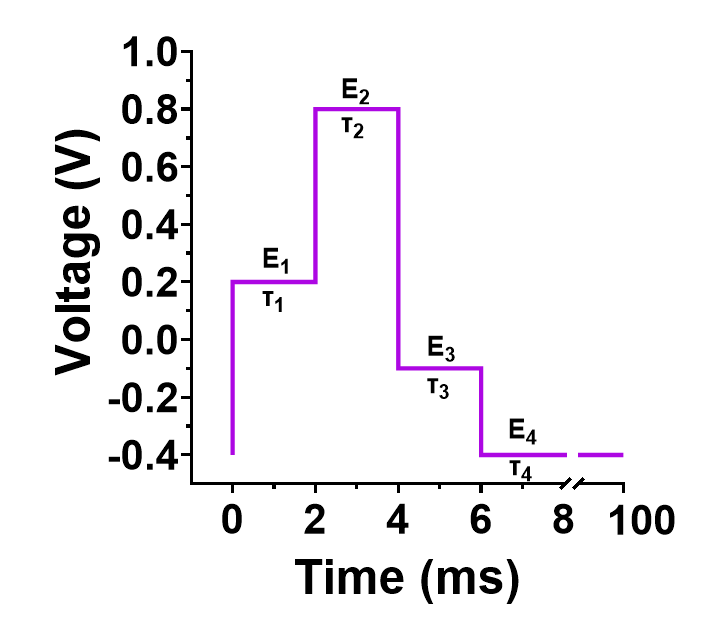

In [3]:
#define search space 
SPACE = [Real(0, 1.3,name='step1_pot'),
         Real(0.5, 2,name='step1_tau'),
         Real(0, 1.3, name='step2_pot'),
         Real(0.5, 2,name='step2_tau'), 
         Real(-0.5, 0, name='step3_pot'), 
         Real(0.5, 2,name='step3_tau'),
         Real(-0.5, 0, name='step4_pot'), 
         Real(0.5, 2,name='step4_tau')]

Note: we can pre-process our inputs as desired. However, because all parameters are roughly on the same scale, we won't do so here. `skopt` also has built in pre-processing that occurs under the hood, so be sure to consult documentation and examine your model properties, as we will do below. See also: https://scikit-optimize.github.io/stable/modules/classes.html#module-skopt.space.transformers

Lucky for you, we already tested a bunch of waveforms and measured their performance and have all the data. But, we will show it to you piece by piece to simulate real-world ask/tell or 'human in the loop' experiments.

Now we will label our known inputs (the waveforms) in a vector **x**.

Each element in **x** is a waveform denoted by parameters defined above. These will represent the first half of our training data, the input waveforms.

The second half of our training data is the output metric corresponding to each waveform. Each waveform in **x** corresponds in order to that metric in **fx**, because we have tested all these waveforms and calculated their metrics experimentally (i.e., a function of x, hence, f(x), or just fx). 

We started by generating 6 (arbritratry; could be more or less) waveforms to 'initialize' the search space. For example, we used a random number generator, constrained as needed denoted above, to generate each parameter in **x** shown below. Then, we built and tested all 6 waveforms on measuring serotonin in the lab, resulting in one metric in **fx** per waveform in **x**, shown below.


In [4]:
# vectorized waveform parameters
# [E1 t1 E2 t2 E3 t3 E4 t4]

x = [[0.8,0.5,0.5,0.5,-0.3,1.0,-0.1,1.5], 
     [0.9,0.5,0.7,1.0,-0.4,0.5,-0.3,1.5], 
     [0.5,2.0,0.2,1.5,-0.1,1.5,-0.3,1.0], 
     [0.6,2.0,0.8,0.5,-0.2,2.0,-0.4,0.5], 
     [0.2,1.0,0.3,1.5,-0.1,1.5,-0.0,0.5], 
     [0.7,1.5,0.6,2.0,-0.3,1.0,-0.1,2.0]] 

#output mean absolute error (MAE) 5-HT test set accuracy in nanomolar (nM)
#CONSTRAINED > 0
fx = [24.113095,24.101953,39.286473,30.566996,96.723507,27.557131]

# Optimization

Now we define our optimizer as such. Using the search space defined above, we'll use a Gaussian process (GP) as our surrogate model, along with Expected Improvement (EI) as the acquistion function. Other arguments we leave as defaults. The initial point generator and number of initial points are required, but we already know the six initial waveforms we want to use (as defined above in **x**).

See here for reference: https://scikit-optimize.github.io/stable/modules/generated/skopt.optimizer.Optimizer.html#skopt.optimizer.Optimizer

In [18]:
opt = Optimizer(SPACE, "GP", acq_func="EI",
                initial_point_generator="lhs",
                n_initial_points=6)

For example, if you wanted to generate 6 initialization waveforms using Latin hypercube sampling, because you had not already generated your initialization waveforms, you could do something like:

In [19]:
next_x = opt.ask(6)
print(next_x)

[[0.5547871395694032, 1.9738684129488937, 0.27963279243548705, 0.8372953183520018, -0.33041800591910553, 1.7015644902781726, -0.1603799997641549, 0.7515657678849931], [1.0289697301572946, 0.8958628829469741, 0.4530705386776338, 0.5083912537754269, -0.11266725014954282, 0.5311260523540591, -0.28762426728239027, 1.150296803177651], [0.21317431886337215, 0.5692956285409624, 0.7561229390814556, 1.0496323856562126, -0.22150707673877962, 1.9024098015761006, -0.33616166619504173, 1.4331434869060624], [1.2648700505138248, 1.5667415565375002, 0.01329856826152103, 1.5657361393628566, -0.03322048356391305, 1.484738106458405, -0.1674113431134432, 1.9611063603241476], [0.6707447983526712, 1.0046757772651467, 1.0944492437400921, 1.3493014446773317, -0.41143621127834723, 0.8908906966511894, -0.46704993781525506, 0.5590674978964031], [0.238061168582943, 1.4487642607713205, 0.9238895264177265, 1.8794360648282749, -0.43201618259380337, 1.0131641904557644, -0.016445167966192054, 1.6394986797985087]]


Each 8-element vector here is a waveform generated using the Latin hyercube sampling method. Then, you would go and measure the performance of each of these waveforms, and come back and enter them. You can change your initialization generator to different strategies as desired. See `skopt` documentation.

However, as mentioned, we have already generated and tested the 6 random waveforms listed above, so we can skip this step.

So, instead, we simply need to tell our optimizer the waveforms and results we have already acquired so it can train, built, and query its surrogate model for the next best waveform for us to run in lab.

# Ask/Tell Mode

To do so, we use something called `ask`/`tell` mode. See: https://scikit-optimize.github.io/stable/auto_examples/ask-and-tell.html#sphx-glr-auto-examples-ask-and-tell-py

First we need to `tell` the model what training data we have.

In [20]:
res=opt.tell(x,fx);

print(opt.models)

[GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1219857901)]


As you can see, a GP was built.

Now, we can ask for the next best waveform. Note, this returns a vectorized waveform in the same format we fed the inputs.

In [21]:
next_x = opt.ask()
print(next_x)

[1.3, 0.5, 0.0, 0.5, 0.0, 2.0, -0.5, 0.5]


We can plot the waveform to get a better idea of how it looks.

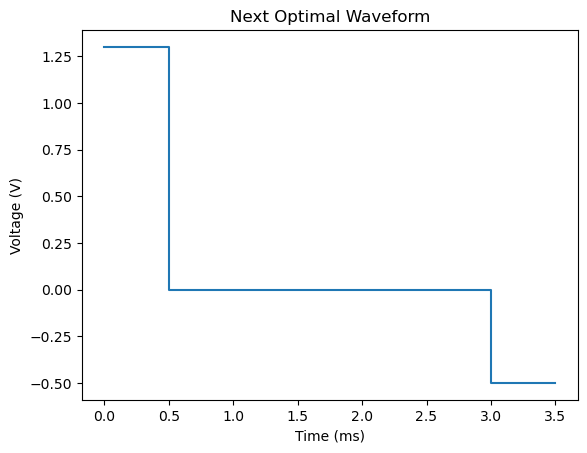

In [22]:
x_plt = [0,next_x[1],next_x[1],next_x[3]+next_x[1],next_x[3]+next_x[1],next_x[3]+next_x[1]+next_x[5],
         next_x[3]+next_x[1]+next_x[5],next_x[3]+next_x[1]+next_x[5]+next_x[7]]

y_plt = [next_x[0],next_x[0],next_x[2],next_x[2],next_x[4],next_x[4],next_x[6],next_x[6]]

plt.plot(x_plt,y_plt);
plt.ylabel('Voltage (V)');
plt.xlabel('Time (ms)');
plt.title('Next Optimal Waveform');

Here is where you would go build and test this waveform in the lab.

Then, you would return here, and `tell` the model your new result of `fx` evaluated at `next_x`. The model then updates and predicts again. 


You can also save and load your models here.

In [24]:
import pickle

with open('my-optimizer.pkl', 'wb') as f:
    pickle.dump(opt, f)

with open('my-optimizer.pkl', 'rb') as f:
    opt_restored = pickle.load(f)

More advanced users can checkout running parralel runs, creating checkpoints, etc. See: https://scikit-optimize.github.io/stable/auto_examples/interruptible-optimization.html#sphx-glr-auto-examples-interruptible-optimization-py

In [25]:
opt.models[0]

GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1219857901)

Here, we won't actually test the waveform predicted above in this notebook. This is just shown for demo purposes, as we are limited by the waveforms we acquired using this apporach previously.

Instead, we pretend as if we generated a batch of 8 new waveforms to try from the above, went into lab and performed the physical experiments on them, and came back and entered in their metrics. We will call this batch x_2 and fx_2.

In [27]:
x_2 = [[0.308,1.6,0.385,1.0,-0.397,1.5,-0.268,0.6], 
     [0.747,1.0,0.499,1.9,-0.309,0.8,-0.237,0.5], 
     [0.113,0.9,0.930,1.7,-0.243,1.4,-0.056,1.0],
     [0.291,1.7,0.106,0.9,-0.165,1.6,-0.393,0.6],
     [0.815,1.0,1.105,1.1,-0.379,1.2,-0.137,1.5],
     [0.163,1.4,0.972,1.9,-0.080,1.9,-0.051,1.5],
     [0.747,0.5,1.251,0.5,-0.162,0.8,-0.324,1.9], 
     [0.362,0.7,0.524,2.0,-0.333,1.6,-0.291,0.9]]

fx_2 = [92.177546,41.448567,32.24483,73.078649,40.975311,24.363601,64.803313,21.436404]

Then we again `tell` the model what we did.

In [28]:
res=opt.tell(x_2,fx_2);

print(opt.models)

[GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1219857901), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1219857901)]


Now the process repeats. We ask it what to do next.

In [29]:
next_x = opt.ask()
print(next_x)

[0.4100878610407748, 0.5, 0.6417748330666663, 2.0, -0.3470489911304975, 1.6011212944270055, -0.3364849915352349, 0.9952087665550993]


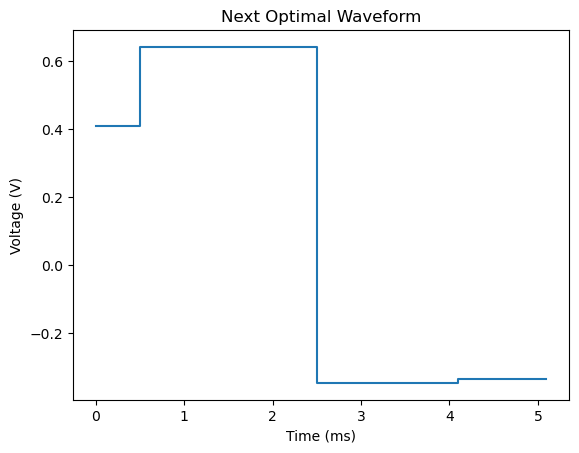

In [30]:
x_plt = [0,next_x[1],next_x[1],next_x[3]+next_x[1],next_x[3]+next_x[1],next_x[3]+next_x[1]+next_x[5],
         next_x[3]+next_x[1]+next_x[5],next_x[3]+next_x[1]+next_x[5]+next_x[7]]

y_plt = [next_x[0],next_x[0],next_x[2],next_x[2],next_x[4],next_x[4],next_x[6],next_x[6]]

plt.plot(x_plt,y_plt);
plt.ylabel('Voltage (V)');
plt.xlabel('Time (ms)');
plt.title('Next Optimal Waveform');

We'll do this twice more for a total of four iterations. 

In [33]:
x_3 =[[0.102,1.3,0.092,0.6,-0.350,0.8,-0.321,1.8],
     [0.517,0.7,0.806,1.9,-0.098,1.8,-0.493,1.3], 
     [0.437,0.8,0.548,1.9,-0.291,1.7,-0.282,0.9], 
     [0.646,1.0,0.171,1.8,-0.236,1.5,-0.218,1.7],
     [0.351,1.1,0.784,0.9,-0.350,0.6,-0.209,0.5],
     [0.325,1.7,1.255,1.2,-0.109,1.3,-0.306,1.0],
     [0.105,0.9,0.303,1.8,-0.009,0.8,-0.066,1.0],
     [0.004,2.0,0.598,0.9,-0.212,2.0,-0.161,1.4]]

fx_3 = [111.044765,21.40178,76.415113,26.143216,37.528236,41.08743,69.179323,15.91894]

In [34]:
res=opt.tell(x_3,fx_3);

print(opt.models)

[GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1219857901), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1219857901), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1219857901)]


In [35]:
next_x = opt.ask()
print(next_x)

[0.9591396445928108, 1.3278194517208335, 0.1847015921032812, 0.9507535021250783, 0.0, 2.0, -0.26398292395627054, 2.0]


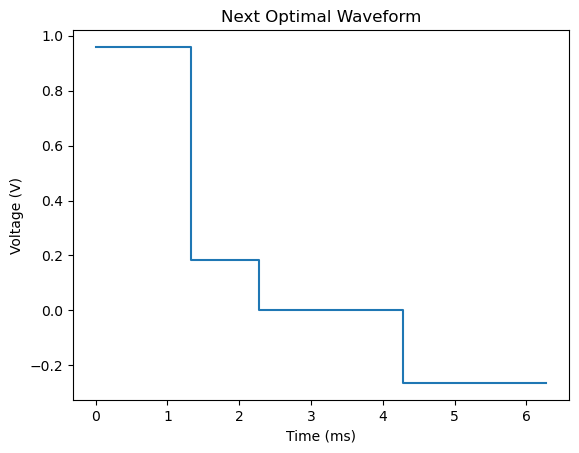

In [36]:
x_plt = [0,next_x[1],next_x[1],next_x[3]+next_x[1],next_x[3]+next_x[1],next_x[3]+next_x[1]+next_x[5],
         next_x[3]+next_x[1]+next_x[5],next_x[3]+next_x[1]+next_x[5]+next_x[7]]

y_plt = [next_x[0],next_x[0],next_x[2],next_x[2],next_x[4],next_x[4],next_x[6],next_x[6]]

plt.plot(x_plt,y_plt);
plt.ylabel('Voltage (V)');
plt.xlabel('Time (ms)');
plt.title('Next Optimal Waveform');

In [38]:
x_4 = [[0.128,1.9,1.248,1.9,-0.469,0.9,-0.109,1.9],
     [0.274,0.7,0.779,1.5,-0.180,1.9,-0.425,1.4], 
     [0.578,1.0,0.856,0.9,-0.298,1.5,-0.141,1.7],
     [0.837,1.9,1.074,0.5,-0.096,1.9,-0.300,0.7],
     [0.770,0.8,0.945,1.5,-0.266,1.3,-0.394,1.5],
     [0.000,1.5,0.560,1.8,-0.216,1.2,-0.154,1.3],
     [0.315,1.4,1.289,0.5,-0.479,0.7,-0.293,1.0],
     [0.226,0.8,0.286,1.8,-0.465,0.8,-0.359,0.9]]

fx_4 = [47.059236,18.596192,50.695909,46.766311,28.936594,29.354428,36.690697,71.211210]

In [39]:
res=opt.tell(x_4,fx_4);

print(opt.models)

[GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1219857901), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1219857901), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1219857901), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normali

In [40]:
next_x = opt.ask()
print(next_x)

[0.0, 1.5414609791327163, 0.7690279277594114, 2.0, 0.0, 1.3646464686927686, -0.5, 1.6672219061634674]


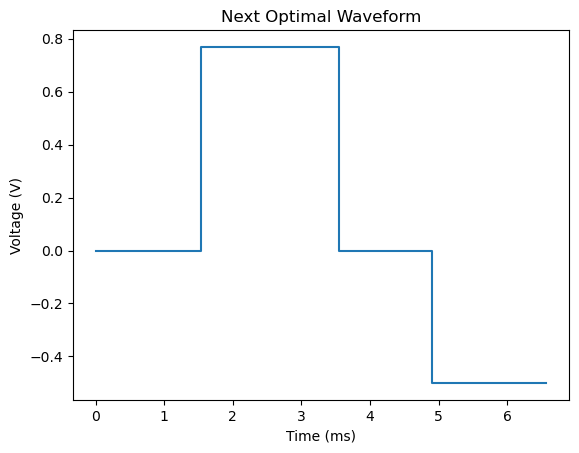

In [41]:
x_plt = [0,next_x[1],next_x[1],next_x[3]+next_x[1],next_x[3]+next_x[1],next_x[3]+next_x[1]+next_x[5],
         next_x[3]+next_x[1]+next_x[5],next_x[3]+next_x[1]+next_x[5]+next_x[7]]

y_plt = [next_x[0],next_x[0],next_x[2],next_x[2],next_x[4],next_x[4],next_x[6],next_x[6]]

plt.plot(x_plt,y_plt);
plt.ylabel('Voltage (V)');
plt.xlabel('Time (ms)');
plt.title('Next Optimal Waveform');

As you can see, we trained four total models. We could keep going in this loop over and over.  But we're out of data, so let's stop here and examine our progress.

# Progress Plots

Along the way, we can visualize our waveforms and waveform parameters.

See: https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_evaluations.html#skopt.plots.plot_evaluations

All our optimization is saved in the following object:

In [42]:
res

          fun: 15.91894
    func_vals: array([ 24.113095,  24.101953,  39.286473,  30.566996,  96.723507,
        27.557131,  92.177546,  41.448567,  32.24483 ,  73.078649,
        40.975311,  24.363601,  64.803313,  21.436404, 111.044765,
        21.40178 ,  76.415113,  26.143216,  37.528236,  41.08743 ,
        69.179323,  15.91894 ,  47.059236,  18.596192,  50.695909,
        46.766311,  28.936594,  29.354428,  36.690697,  71.21121 ])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1219857901), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1219857901), GaussianProcessRegressor

In [43]:
base_res=res
base_model=opt.models[-1]
base_res_model=res.models[-1]

Note how `res` shows the current best minima as `fun` and best waveform as `x`.

You can also visualize as the waveforms you tried to see how spread out they are in parameter space.

Per `skopt` documentation: The diagonal shows histograms for each of the dimensions. In the lower triangle, a two dimensional scatter plot of all points is shown. The order in which points were evaluated is encoded in the color of each point. Darker/purple colors correspond to earlier samples and lighter/yellow colors correspond to later samples. A red point shows the location of the minimum found by the optimization process.

Note how points start clustering around the location of the true miminum (yellow-ish points around red stars). The histograms show that the objective is evaluated more often at locations near to one of the minima.

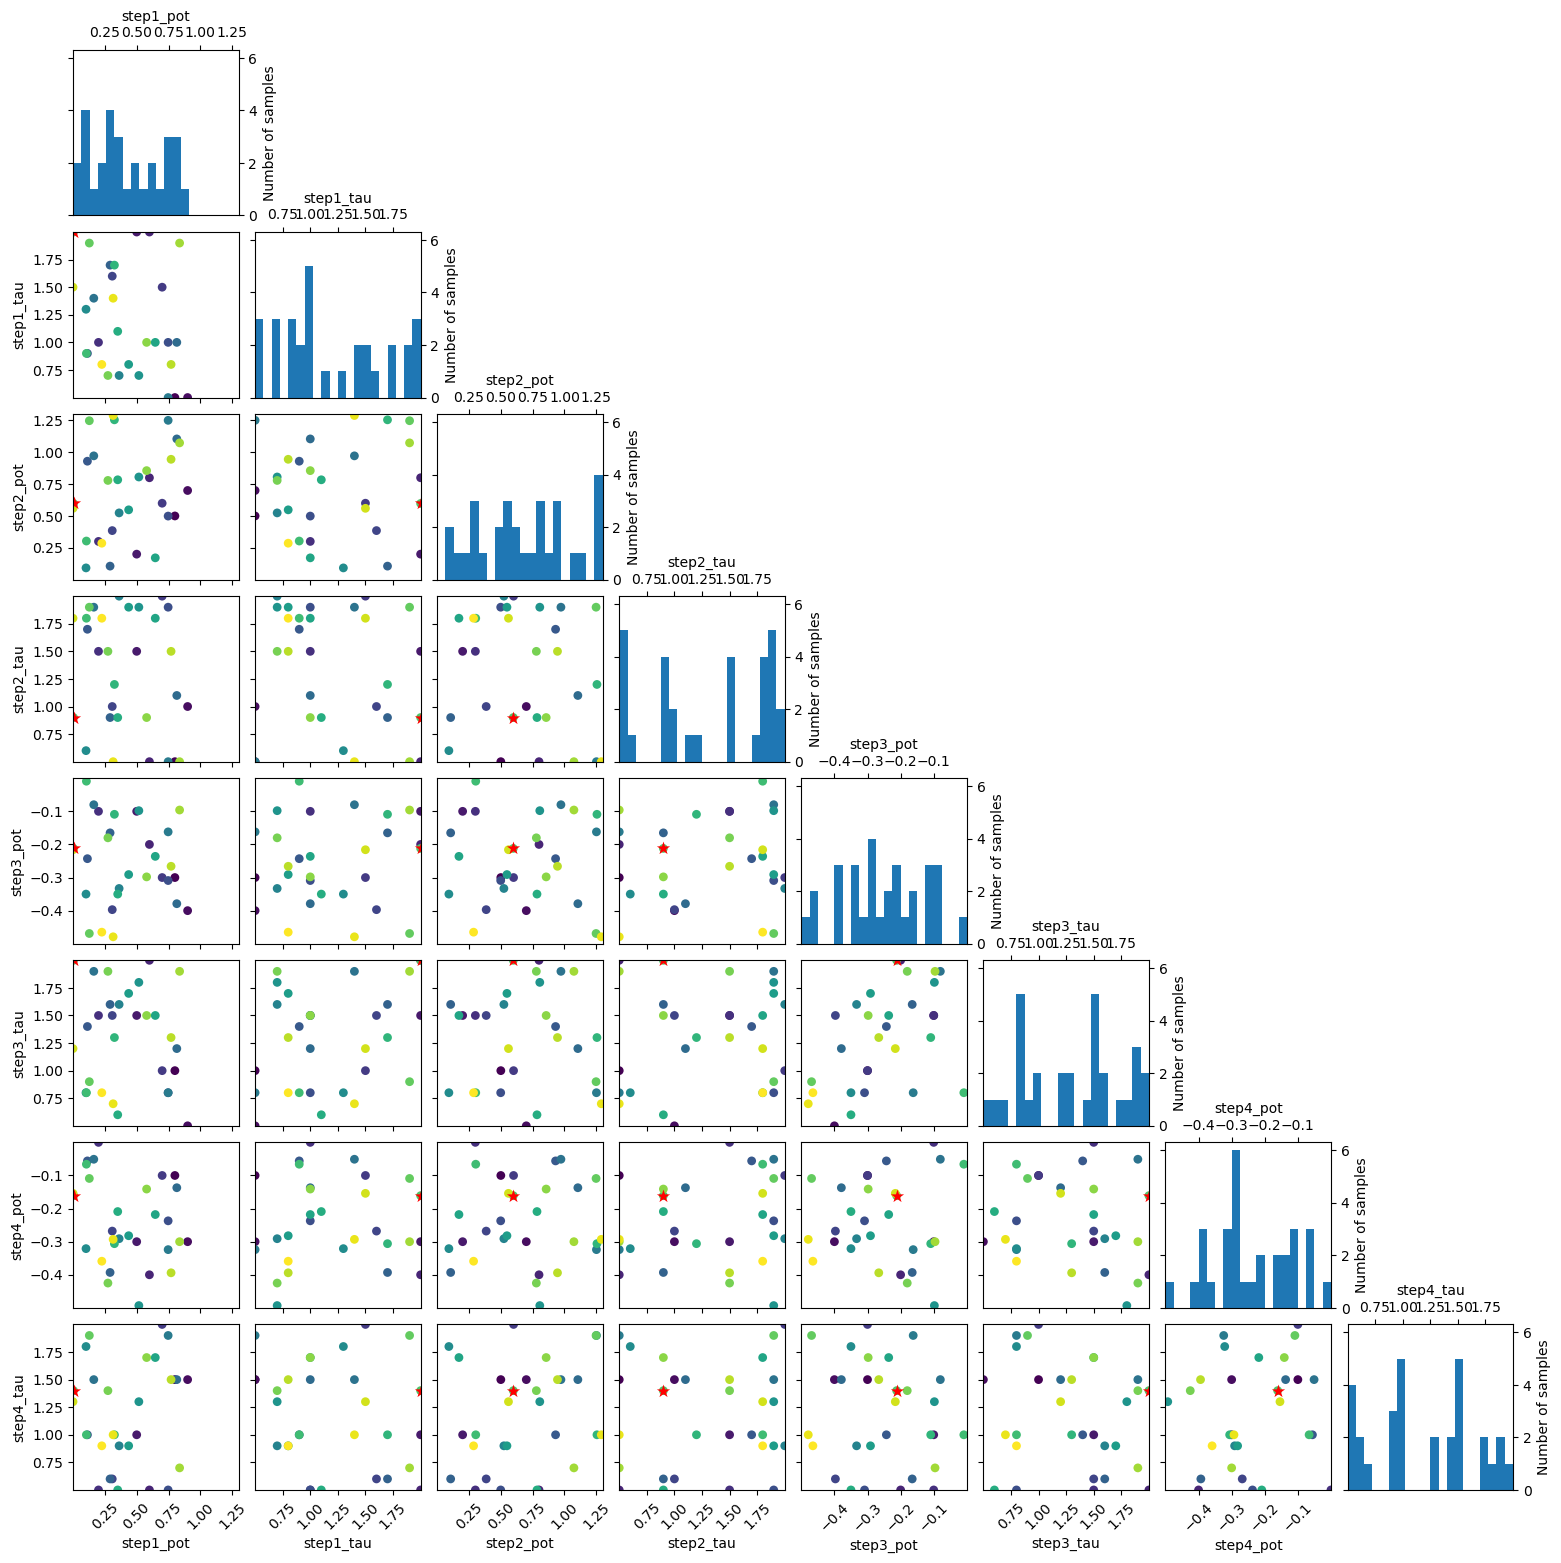

In [45]:
plot_evaluations(res);

We can also visualize how the metric performs over time through a covnergence plot. Note that this only shows the current minima at each iteration.

See: https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_convergence.html#skopt.plots.plot_convergence

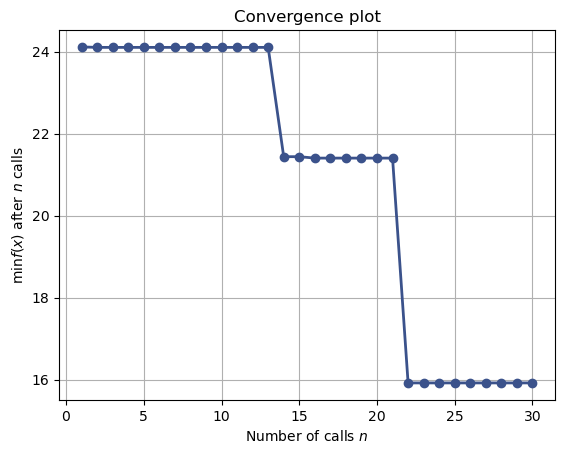

In [46]:
plot_convergence(res);

As you can see, we find an improved waveform in each round of that we test!

# Partial Depedence Plots (PDPs)

Another built in plotting tool in `skopt` are Partial Dependence Plots (PDPs). See: https://scikit-optimize.github.io/stable/auto_examples/plots/partial-dependence-plot.html#sphx-glr-auto-examples-plots-partial-dependence-plot-py

The PDPs show the influence of each waveform parameter on sensor error. We can plot the PDP using the latest model (i.e., GPR model; `res` defined above) as shown below. 

The diagonal 1D plots show how that waveform parameter varies along the x-dimension and effects the optimization metric (via a 'partial dependence' value') on the y-axis. The partial dependence can be thought of as the average value of the metric when all other parameters, except the one plotted on the x-axis, are varied randomly. This gives the effect of only that metric.

Below the diagonal are 2-D contour plots that show varying waveform parameters on the x- and y-axis, where the color represents the partial dependence (yellow being larger (worse) waveform performance, dark purple being best (minima)). Because we can only visualize up to 3-D, we can only plot 1 or 2 waveform parameters as PDPs.

In the 1D plots, the red line indicates parameter value at the best observed minimum; similarly, in the 2D plots, a red star indicates the parameter values at the best observed minimum. The black dots represent the points actually sampled during optimization (e.g., our actual waveform training data!).

https://matplotlib.org/stable/gallery/color/colormap_reference.html

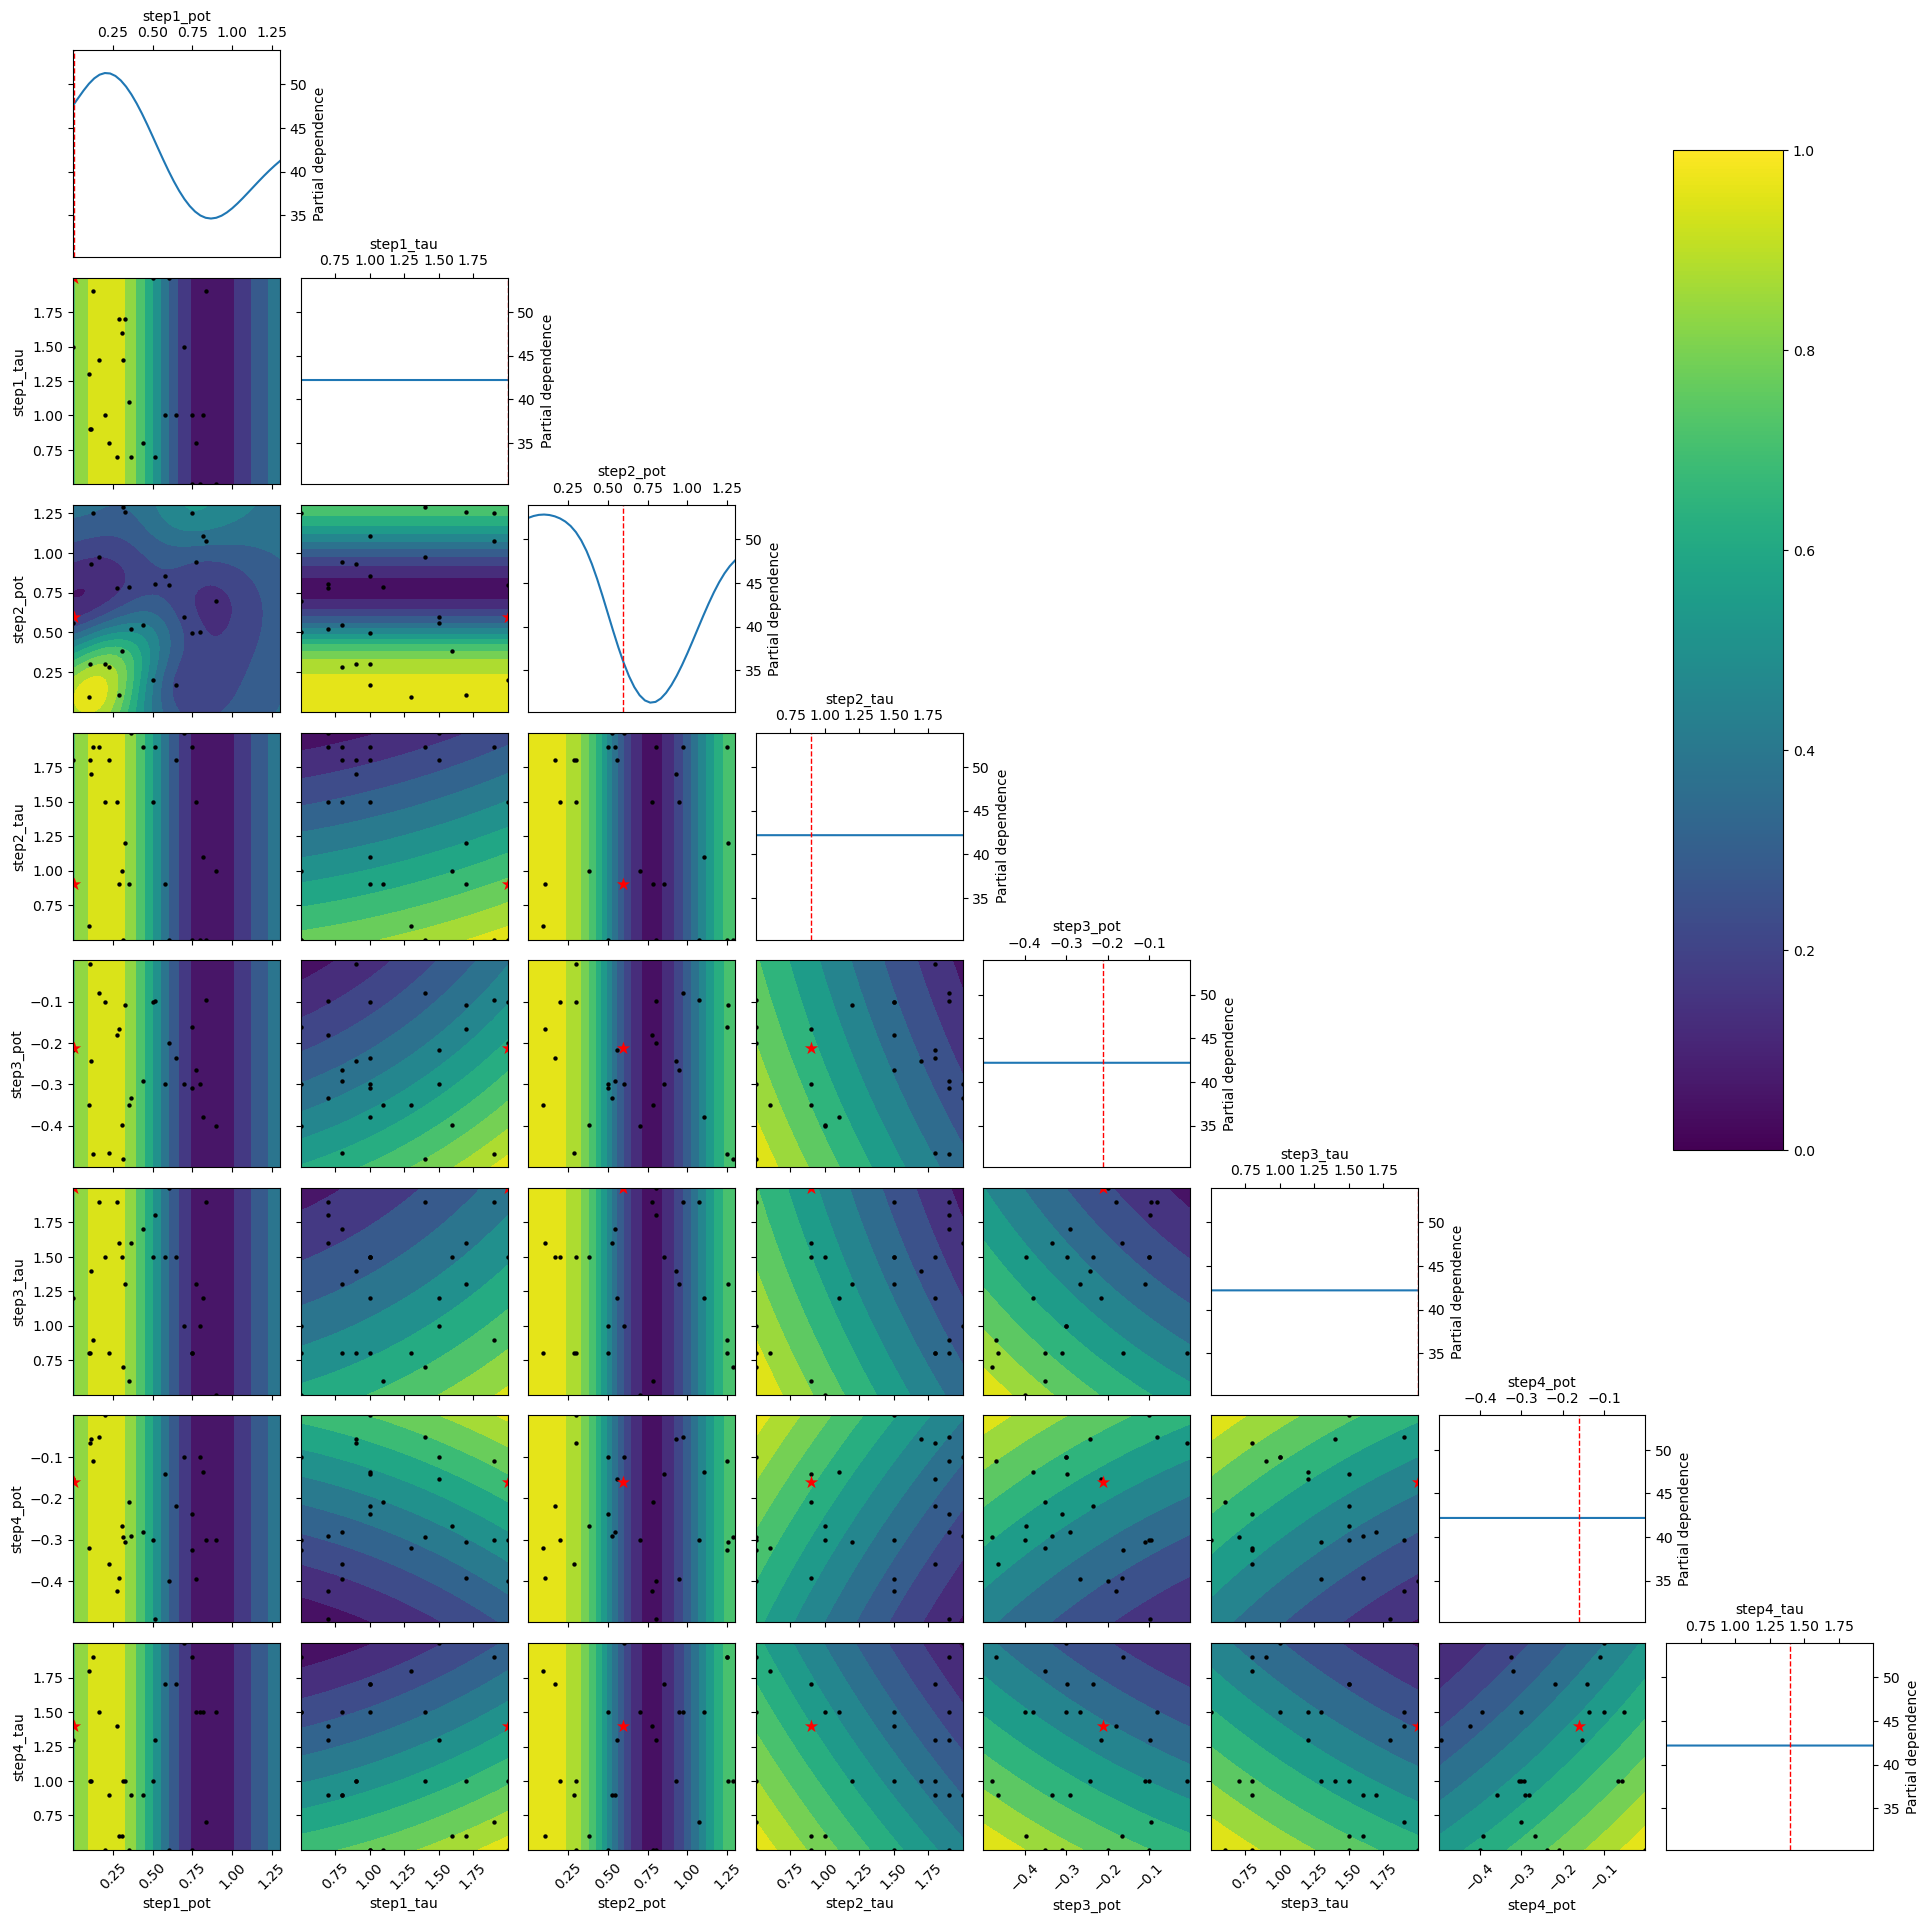

In [59]:
plot_objective(res,cmap='viridis');
fig = plt.gcf()
fig.set_size_inches(20,20)
cax = plt.axes((0.85, 0.4, 0.055, 0.5))
fig.colorbar(cm.ScalarMappable(cmap='viridis'),cax=cax)

There are also many plotting parameters you can alter to explore your model, so check out the skopt documentation. https://scikit-optimize.github.io/stable/auto_examples/plots/partial-dependence-plot.html#sphx-glr-auto-examples-plots-partial-dependence-plot-py

Briefly, PDPs are on method to interpret the importance of your one or two of your inputs on your surrogate model, by randomly averaging out the effects of the remaining inputs. Flat plots above may be considered uninformative, compared to the plots with more varied structure (e.g., `E1` and `E2`). Thus, for our model, it appears the most important tradeoff occurs between setting the E1 and E2 steps.

And thats it! You've built, tested, and interpreted a Bayesian optimization campaign.

---------------------------------------------------
Note: When running the model manually, an extremely important consideration is to pre-process your data correctly. The GP we extracted from `res` was trained on data already pre-processed in some manner. To find out how, if you are unsure:

In [64]:
res.space

Space([Real(low=0, high=1.3, prior='uniform', transform='normalize'),
       Real(low=0.5, high=2, prior='uniform', transform='normalize'),
       Real(low=0, high=1.3, prior='uniform', transform='normalize'),
       Real(low=0.5, high=2, prior='uniform', transform='normalize'),
       Real(low=-0.5, high=0, prior='uniform', transform='normalize'),
       Real(low=0.5, high=2, prior='uniform', transform='normalize'),
       Real(low=-0.5, high=0, prior='uniform', transform='normalize'),
       Real(low=0.5, high=2, prior='uniform', transform='normalize')])